In [3]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [13]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_gnn_dataset import SolutionDataset

dataset = SolutionDataset(root='../../data/raw')

In [14]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')



Dataset: SolutionDataset(50000):
Number of graphs: 50000
Number of features: 139


/Users/andy/workplace/code-classifier/.venv/lib/python3.9/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  data_dict[key] = torch.as_tensor(value)


In [15]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [16]:
x1, y1 = printstats(0)
x2, y2 = printstats(-1)


Data(edge_index=[2, 165], name=[166], cooccurrences=[166, 139], num_nodes=166, x=[166, 139], y=[100])
Number of nodes: 166
Number of edges: 165
Average node degree: 0.99
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[-0.1187, -0.1187, -0.1187,  ..., -0.1187, -0.1187, -0.1187],
        [-0.1707, -0.1707, -0.1707,  ..., -0.1707, -0.1707, -0.1707],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        ...,
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231],
        [-0.1515, -0.1515,  0.9832,  ...,  0.1190, -0.0980, -0.1515],
        [-0.1231, -0.1231, -0.1231,  ..., -0.1231, -0.1231, -0.1231]])
Data.y: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[0].y.size(-1)

print(NODE_FEATURES)
print(NUM_CLASSES)


139
100


In [ ]:
assert (len(dataset) % 10 == 0)
split = (len(dataset) * 9) // 10

train_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 != 0]
test_dataset = [item for i, item in enumerate(dataset) if (i + 1) % 10 == 0]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


Number of test graphs: 5000


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    data = data.to(device)
    
    if (step) % 2500 == 0:
        print(f'Step {step}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        # self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.lin = Linear(NODE_FEATURES, NUM_CLASSES)

    def forward(self, x, edge_index, batch):
        # x = self.conv1(x, edge_index)

        x = global_mean_pool(x, batch)  
        
        # x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


model = GCN(hidden_channels=512).to(device) 
print(model)

GCN(
  (lin): Linear(in_features=139, out_features=100, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [86]:
EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}
epoch_accuracies = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Progress"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        yTrue = batch.y.float().reshape(1, NUM_CLASSES)
        loss = criterion(out, yTrue)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        max_idx = torch.argmax(out)
        predicted = torch.zeros_like(out)
        predicted[0][max_idx] = 1
        correct += 1 if (torch.equal(predicted, batch.y.float().reshape(1, NUM_CLASSES))) else 0
        total += 1
    
    epoch_accuracy = correct / total
    epoch_losses[epoch + 1] = epoch_loss
    epoch_accuracies[epoch + 1] = epoch_accuracy
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Correct: {correct}, Total: {total}, Accuracy: {epoch_accuracy:.4f}")

print("Training completed.")


Epoch 1/50 Progress: 100%|██████████| 45000/45000 [00:25<00:00, 1745.96it/s]


Epoch 1/50, Loss: 66483.1259, Correct: 27078, Total: 45000, Accuracy: 0.6017


Epoch 2/50 Progress: 100%|██████████| 45000/45000 [00:26<00:00, 1678.32it/s]


Epoch 2/50, Loss: 40910.1662, Correct: 33870, Total: 45000, Accuracy: 0.7527


Epoch 3/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1665.70it/s]


Epoch 3/50, Loss: 37023.1044, Correct: 35166, Total: 45000, Accuracy: 0.7815


Epoch 4/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1637.08it/s]


Epoch 4/50, Loss: 34933.2803, Correct: 35944, Total: 45000, Accuracy: 0.7988


Epoch 5/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1626.84it/s]


Epoch 5/50, Loss: 33756.6071, Correct: 36338, Total: 45000, Accuracy: 0.8075


Epoch 6/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1633.94it/s]


Epoch 6/50, Loss: 32558.3673, Correct: 36724, Total: 45000, Accuracy: 0.8161


Epoch 7/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1634.62it/s]


Epoch 7/50, Loss: 32066.2848, Correct: 37026, Total: 45000, Accuracy: 0.8228


Epoch 8/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1636.00it/s]


Epoch 8/50, Loss: 31449.9694, Correct: 37209, Total: 45000, Accuracy: 0.8269


Epoch 9/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1627.76it/s]


Epoch 9/50, Loss: 31181.8823, Correct: 37246, Total: 45000, Accuracy: 0.8277


Epoch 10/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1610.12it/s]


Epoch 10/50, Loss: 30901.9821, Correct: 37454, Total: 45000, Accuracy: 0.8323


Epoch 11/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1632.75it/s]


Epoch 11/50, Loss: 30194.8082, Correct: 37699, Total: 45000, Accuracy: 0.8378


Epoch 12/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1633.10it/s]


Epoch 12/50, Loss: 30062.3617, Correct: 37793, Total: 45000, Accuracy: 0.8398


Epoch 13/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1635.81it/s]


Epoch 13/50, Loss: 29979.5990, Correct: 37886, Total: 45000, Accuracy: 0.8419


Epoch 14/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1618.67it/s]


Epoch 14/50, Loss: 29598.7305, Correct: 37937, Total: 45000, Accuracy: 0.8430


Epoch 15/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1637.45it/s]


Epoch 15/50, Loss: 29429.9404, Correct: 38114, Total: 45000, Accuracy: 0.8470


Epoch 16/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1618.88it/s]


Epoch 16/50, Loss: 29303.7514, Correct: 38148, Total: 45000, Accuracy: 0.8477


Epoch 17/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1594.58it/s]


Epoch 17/50, Loss: 29171.1647, Correct: 38163, Total: 45000, Accuracy: 0.8481


Epoch 18/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1626.25it/s]


Epoch 18/50, Loss: 29168.5270, Correct: 38315, Total: 45000, Accuracy: 0.8514


Epoch 19/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1624.82it/s]


Epoch 19/50, Loss: 28975.5969, Correct: 38213, Total: 45000, Accuracy: 0.8492


Epoch 20/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1595.73it/s]


Epoch 20/50, Loss: 28556.8777, Correct: 38380, Total: 45000, Accuracy: 0.8529


Epoch 21/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1620.75it/s]


Epoch 21/50, Loss: 28599.1732, Correct: 38407, Total: 45000, Accuracy: 0.8535


Epoch 22/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1657.38it/s]


Epoch 22/50, Loss: 28478.7834, Correct: 38500, Total: 45000, Accuracy: 0.8556


Epoch 23/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1643.12it/s]


Epoch 23/50, Loss: 28519.7209, Correct: 38518, Total: 45000, Accuracy: 0.8560


Epoch 24/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1629.37it/s]


Epoch 24/50, Loss: 28512.0903, Correct: 38639, Total: 45000, Accuracy: 0.8586


Epoch 25/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1643.61it/s]


Epoch 25/50, Loss: 28169.7305, Correct: 38570, Total: 45000, Accuracy: 0.8571


Epoch 26/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1630.10it/s]


Epoch 26/50, Loss: 27904.0829, Correct: 38687, Total: 45000, Accuracy: 0.8597


Epoch 27/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1624.97it/s]


Epoch 27/50, Loss: 27913.9492, Correct: 38588, Total: 45000, Accuracy: 0.8575


Epoch 28/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1616.27it/s]


Epoch 28/50, Loss: 28149.9842, Correct: 38685, Total: 45000, Accuracy: 0.8597


Epoch 29/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1592.47it/s]


Epoch 29/50, Loss: 27978.9228, Correct: 38801, Total: 45000, Accuracy: 0.8622


Epoch 30/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1618.72it/s]


Epoch 30/50, Loss: 27858.6323, Correct: 38801, Total: 45000, Accuracy: 0.8622


Epoch 31/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1651.94it/s]


Epoch 31/50, Loss: 28078.6136, Correct: 38765, Total: 45000, Accuracy: 0.8614


Epoch 32/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1613.35it/s]


Epoch 32/50, Loss: 28060.6948, Correct: 38854, Total: 45000, Accuracy: 0.8634


Epoch 33/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1597.28it/s]


Epoch 33/50, Loss: 27789.2657, Correct: 38899, Total: 45000, Accuracy: 0.8644


Epoch 34/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1605.48it/s]


Epoch 34/50, Loss: 27605.5334, Correct: 38961, Total: 45000, Accuracy: 0.8658


Epoch 35/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1594.12it/s]


Epoch 35/50, Loss: 27760.1164, Correct: 38866, Total: 45000, Accuracy: 0.8637


Epoch 36/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1588.91it/s]


Epoch 36/50, Loss: 27889.5473, Correct: 38955, Total: 45000, Accuracy: 0.8657


Epoch 37/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1631.81it/s]


Epoch 37/50, Loss: 27537.1915, Correct: 39063, Total: 45000, Accuracy: 0.8681


Epoch 38/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1620.90it/s]


Epoch 38/50, Loss: 27657.6110, Correct: 39079, Total: 45000, Accuracy: 0.8684


Epoch 39/50 Progress: 100%|██████████| 45000/45000 [00:28<00:00, 1606.58it/s]


Epoch 39/50, Loss: 27466.4599, Correct: 39014, Total: 45000, Accuracy: 0.8670


Epoch 40/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1623.15it/s]


Epoch 40/50, Loss: 27538.8990, Correct: 39035, Total: 45000, Accuracy: 0.8674


Epoch 41/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1630.54it/s]


Epoch 41/50, Loss: 27677.7575, Correct: 39098, Total: 45000, Accuracy: 0.8688


Epoch 42/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1633.62it/s]


Epoch 42/50, Loss: 27483.9679, Correct: 39037, Total: 45000, Accuracy: 0.8675


Epoch 43/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1633.87it/s]


Epoch 43/50, Loss: 27438.0741, Correct: 39139, Total: 45000, Accuracy: 0.8698


Epoch 44/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1635.52it/s]


Epoch 44/50, Loss: 27370.4717, Correct: 39101, Total: 45000, Accuracy: 0.8689


Epoch 45/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1632.34it/s]


Epoch 45/50, Loss: 27606.3359, Correct: 39171, Total: 45000, Accuracy: 0.8705


Epoch 46/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1637.74it/s]


Epoch 46/50, Loss: 27292.1217, Correct: 39174, Total: 45000, Accuracy: 0.8705


Epoch 47/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1634.20it/s]


Epoch 47/50, Loss: 27375.3291, Correct: 39230, Total: 45000, Accuracy: 0.8718


Epoch 48/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1633.65it/s]


Epoch 48/50, Loss: 27236.1218, Correct: 39193, Total: 45000, Accuracy: 0.8710


Epoch 49/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1624.47it/s]


Epoch 49/50, Loss: 27354.9206, Correct: 39188, Total: 45000, Accuracy: 0.8708


Epoch 50/50 Progress: 100%|██████████| 45000/45000 [00:27<00:00, 1629.55it/s]

Epoch 50/50, Loss: 27219.0939, Correct: 39239, Total: 45000, Accuracy: 0.8720
Training completed.


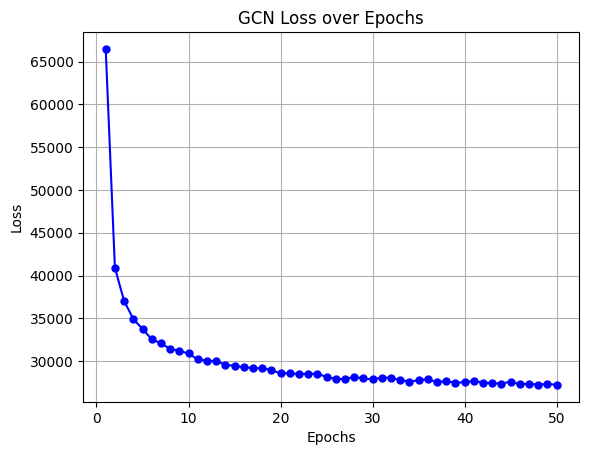

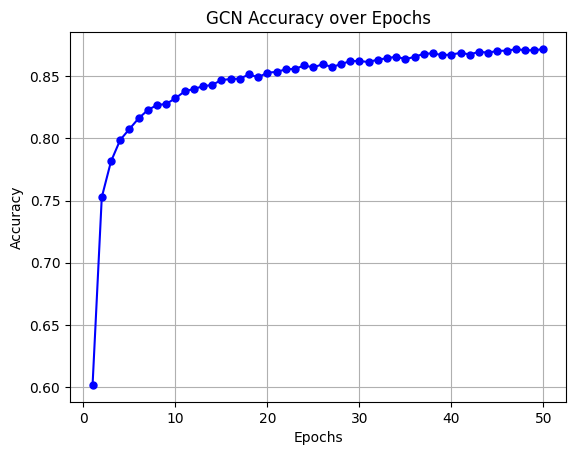

In [87]:
import matplotlib.pyplot as plt

epochs = list(epoch_losses.keys())
losses = list(epoch_losses.values())
accuracies = list(epoch_accuracies.values())

plt.plot(epochs, losses, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GCN Loss over Epochs')
plt.grid(True)
plt.show()

plt.plot(epochs, accuracies, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GCN Accuracy over Epochs')
plt.grid(True)
plt.show()

In [32]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

MODEL_PATH = "GCNModel_6_50epoch_0_layer_full.pth"

In [20]:
torch.save(model, MODEL_PATH)

In [33]:
loaded_model = torch.load(MODEL_PATH)
loaded_model.eval()

/var/folders/qj/2t6cj_5121l_30dkf9rwfbvw0000gn/T/ipykernel_69637/1538415150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(MODEL_PATH)


GCN(
  (lin): Linear(in_features=139, out_features=100, bias=True)
)

Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2335.31it/s]


Top-1 Test Accuracy: 85.90% (4295/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2375.30it/s]


Top-2 Test Accuracy: 93.48% (4674/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2374.26it/s]


Top-3 Test Accuracy: 96.26% (4813/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2362.97it/s]


Top-4 Test Accuracy: 97.14% (4857/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2375.49it/s]


Top-5 Test Accuracy: 97.68% (4884/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2382.44it/s]


Top-6 Test Accuracy: 98.22% (4911/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2386.69it/s]


Top-7 Test Accuracy: 98.58% (4929/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2385.05it/s]


Top-8 Test Accuracy: 98.72% (4936/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2374.42it/s]


Top-9 Test Accuracy: 98.96% (4948/5000)


Testing Progress: 100%|██████████| 5000/5000 [00:02<00:00, 2376.83it/s]

Top-10 Test Accuracy: 99.06% (4953/5000)


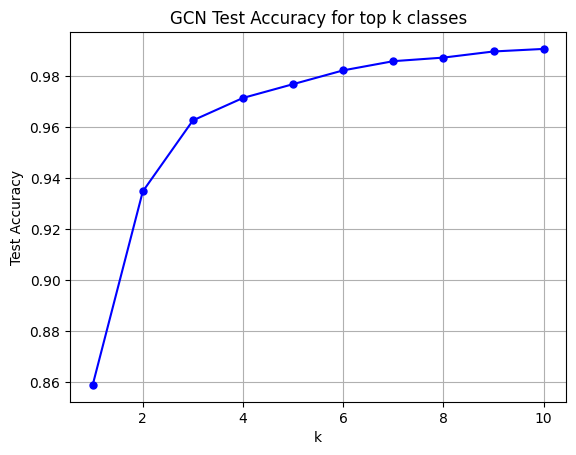

In [35]:
from matplotlib import pyplot as plt

def test(model, test_loader, k=1):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Progress"):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # Output shape: (batch_size, num_classes)
            _, topk_indices = torch.topk(out, k, dim=1)  # Get top k class indices
            true_classes = torch.argmax(batch.y.float().reshape(1, NUM_CLASSES), dim=1)  # True class indices
            # Check if true class is among the top k predictions
            correct_batch = (topk_indices == true_classes.unsqueeze(1)).any(dim=1)
            correct += correct_batch.sum().item()
            total += len(true_classes)
        
    return correct, total, correct / total


test_accuracies = {}

# Compute top 10 test accuracies
for k in range(10):
    correct, total, test_accuracy = test(loaded_model, test_loader, k + 1)
    test_accuracies[k + 1] = test_accuracy
    print(f"Top-{k + 1} Test Accuracy: {test_accuracy * 100:.2f}% ({correct}/{total})")

# Plot test accuracies
ks = list(test_accuracies.keys())
test_accuracy_mappings = list(test_accuracies.values())

plt.plot(ks, test_accuracy_mappings, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('GCN Test Accuracy for top k classes')
plt.grid(True)
plt.show()

In [36]:
from sklearn.decomposition import PCA
from constants import *
NUM_SOLUTIONS = 50

def plot_classifications(classes, k, best=False):
    outputs = []
    labels = []
    bottom_k_labels = []
    i = 0

    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    if best:
        sorted_classes = reversed(sorted_classes)

    for c, entry in sorted_classes:
        if i == k:
            break
        bottom_k_labels.append(c)
        for e in entry[1]:
            outputs.append(e)
            labels.append(c)
        i +=1

    # Concatenate all outputs and labels
    outputs = torch.cat(outputs, dim=0)  # Shape: (num_samples, num_classes)

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    outputs_2d = pca.fit_transform(outputs.numpy())  # Shape: (num_samples, 2)

    # Plot the PCA-transformed outputs
    plt.figure(figsize=(12, 8))

    label_to_index = {label: idx for idx, label in enumerate(bottom_k_labels)}
    indices = np.array([label_to_index[label] for label in labels])

    cmap = plt.cm.get_cmap('nipy_spectral', k)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=indices, cmap=cmap, alpha=0.7)

    # Create a legend mapping colors to class labels
    handles = []
    for idx, label in enumerate(bottom_k_labels):
        color = cmap(idx)
        handles.append(plt.Line2D([], [], marker='o', color=color, linestyle='None',
                                markersize=10, label=f'{FILES[label]} ({(classes[label][0] / NUM_SOLUTIONS) * 100:.0f}%)'))
    plt.legend(handles=handles, title='Problems', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add plot titles and labels
    plt.title(f'Top k = {k} most {"accurately" if best else "poorly"} classified problems')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

In [37]:
def plot_problem_accuracies(classes):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])

    problems = []
    accuracies = []
    for c, entry in sorted_classes:
        problems.append(FILES[c])
        accuracies.append(entry[0] / NUM_SOLUTIONS)

    # Create the bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(problems, accuracies, color='skyblue')

    # Add labels and title
    plt.ylabel('Classification accuracy')
    plt.title('Problem classification accuracy')

    plt.xticks(problems, rotation=60, fontsize=7, ha='right')
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    mean_accuracy = sum(accuracies) / len(sorted_classes)
    plt.axhline(y=mean_accuracy, color='red', linestyle='-', linewidth=1)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [56]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# plots the top k classifications for the n worst performing problems
def plot_misclassifications(classes, n=10, k=5):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    
    problems = {}

    i = 0
    for c, entry in sorted_classes:
        if i == n:
            break
        wrong_problems = []

        counts = {}
        for output in entry[1]:
            max_idx = torch.argmax(output).item()
            if max_idx not in counts:
                counts[max_idx] = 0
            counts[max_idx] += 1

        # del counts[c] # delete correct classification
        counts = list(reversed(sorted(counts.items(), key=lambda item: item[1])))
        # counts = counts[:k]

        total = 0
        for count in counts:
            total += count[1]
        
        rem = total
        j = 0
        for idx, count in counts:
            if j == k:
                break
            wrong_problems.append((idx, count / total))
            rem -= count
            j += 1
        
        if rem > 0:
            wrong_problems.append((-1, rem / total))

        problems[c] = wrong_problems
        i += 1

    cmap = cm.get_cmap("autumn")
    categories = {cat for pie in problems.values() for cat, _ in pie}  # Unique categories
    norm = mcolors.Normalize(vmin=0, vmax=len(categories))
    category_to_color = {category: cmap(norm(idx)) for idx, category in enumerate(sorted(categories))}

    num_charts = len(problems)
    cols = 5  # Number of columns
    rows = (num_charts + cols - 1) // cols

    # Create a figure and axes for each pie chart
    _, axes = plt.subplots(rows, cols, figsize=(30, 30), constrained_layout=True)

    axes = axes.flatten()

    # If there's only one chart, make `axes` iterable
    if len(problems) == 1:
        axes = [axes]

    # Loop through the dictionary to create each pie chart
    for ax, (chart_name, categories) in zip(axes, problems.items()):
        # Extract names and percentages
        names, percentages = zip(*categories)

        colors = []
        for name in names:
            if name != chart_name:
                colors.append(category_to_color[name])
            else:
                colors.append('lightgreen')

        names = [FILES[j] if j != -1 else 'other' for j in names]
        
        # Create the pie chart
        wedges, _, autotexts = ax.pie(percentages, startangle=90, radius=1.0, colors=colors, autopct=custom_autopct)
        ax.set_title(FILES[chart_name], fontsize=10)

        # Add a legend mapping colors to names
        ax.legend(wedges, names, loc="center left", bbox_to_anchor=(1, 0.5),
              fontsize='small', markerscale=0.7, labelspacing=0.3)
        
        # Make the percentages smaller
        for autotext in autotexts:
            autotext.set_fontsize(8)  # Set smaller font size for percentages

    # Hide any extra subplot axes
    for ax in axes[num_charts:]:
        ax.axis('off')

    # Adjust layout to prevent overlapping
    plt.suptitle(f'Top classifications for the {n} most poorly classified problems\n')
    plt.show()

def custom_autopct(pct):
    return f"{pct:.1f}%" if pct > 5 else ""


/var/folders/qj/2t6cj_5121l_30dkf9rwfbvw0000gn/T/ipykernel_69637/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


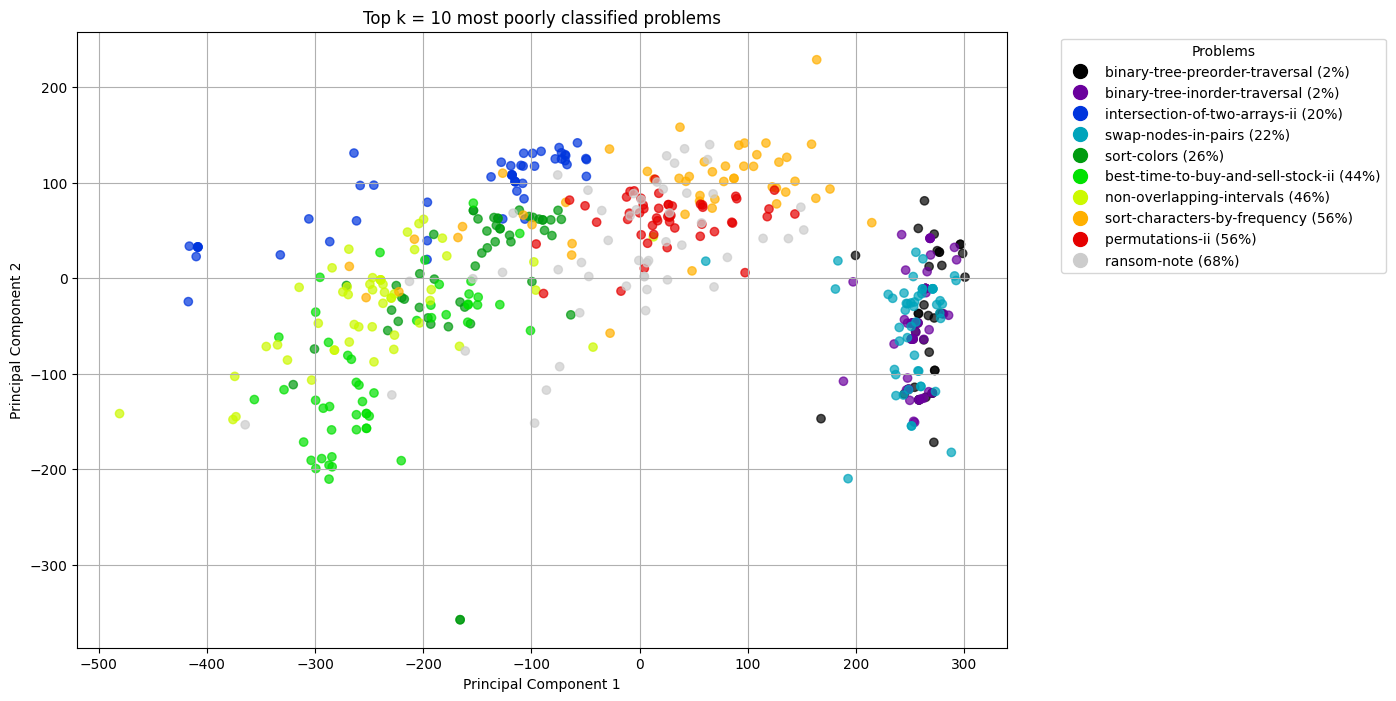

/var/folders/qj/2t6cj_5121l_30dkf9rwfbvw0000gn/T/ipykernel_69637/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


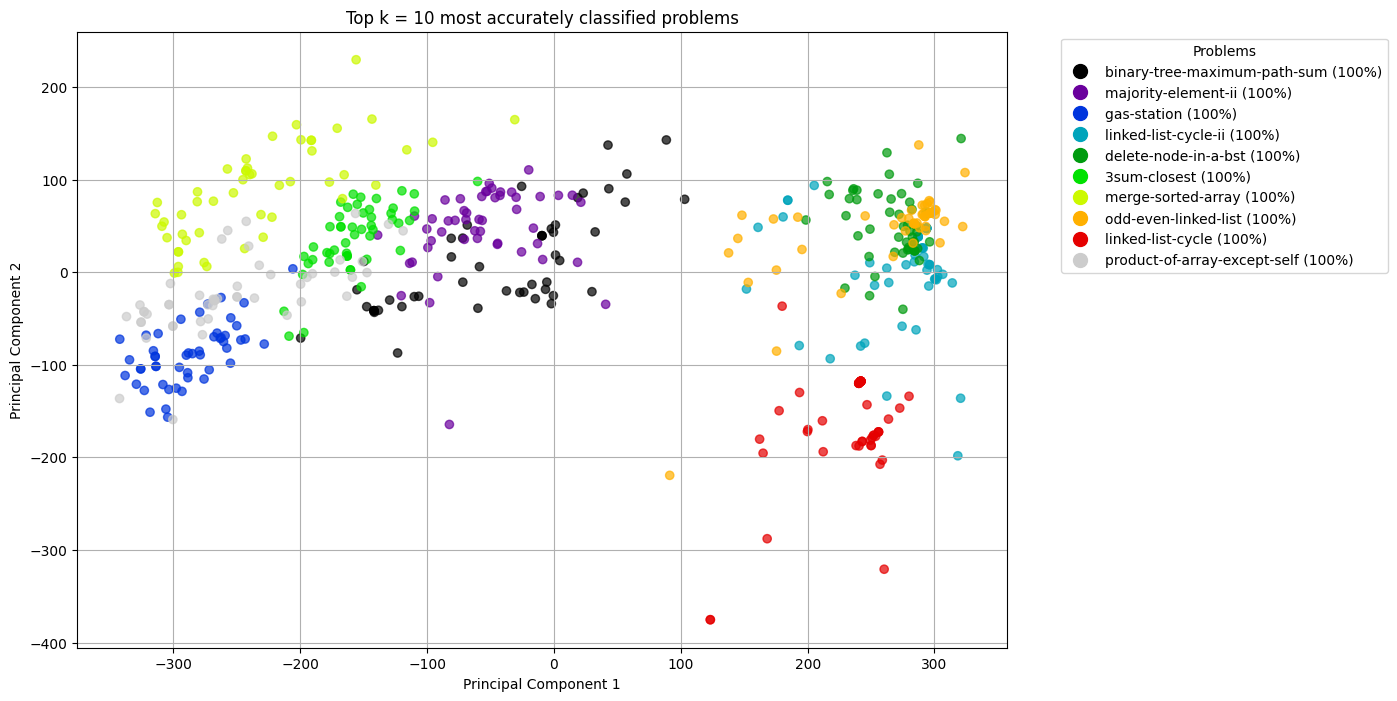

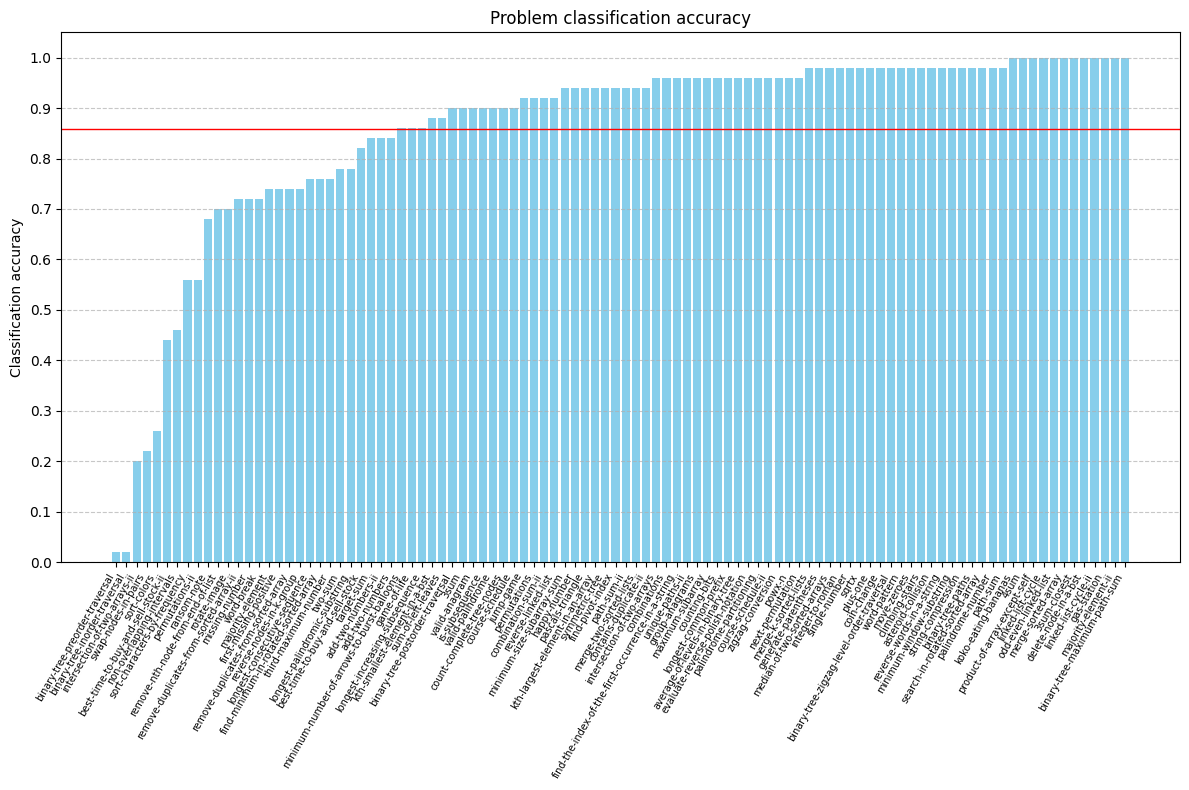

/var/folders/qj/2t6cj_5121l_30dkf9rwfbvw0000gn/T/ipykernel_69637/673163559.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("autumn")


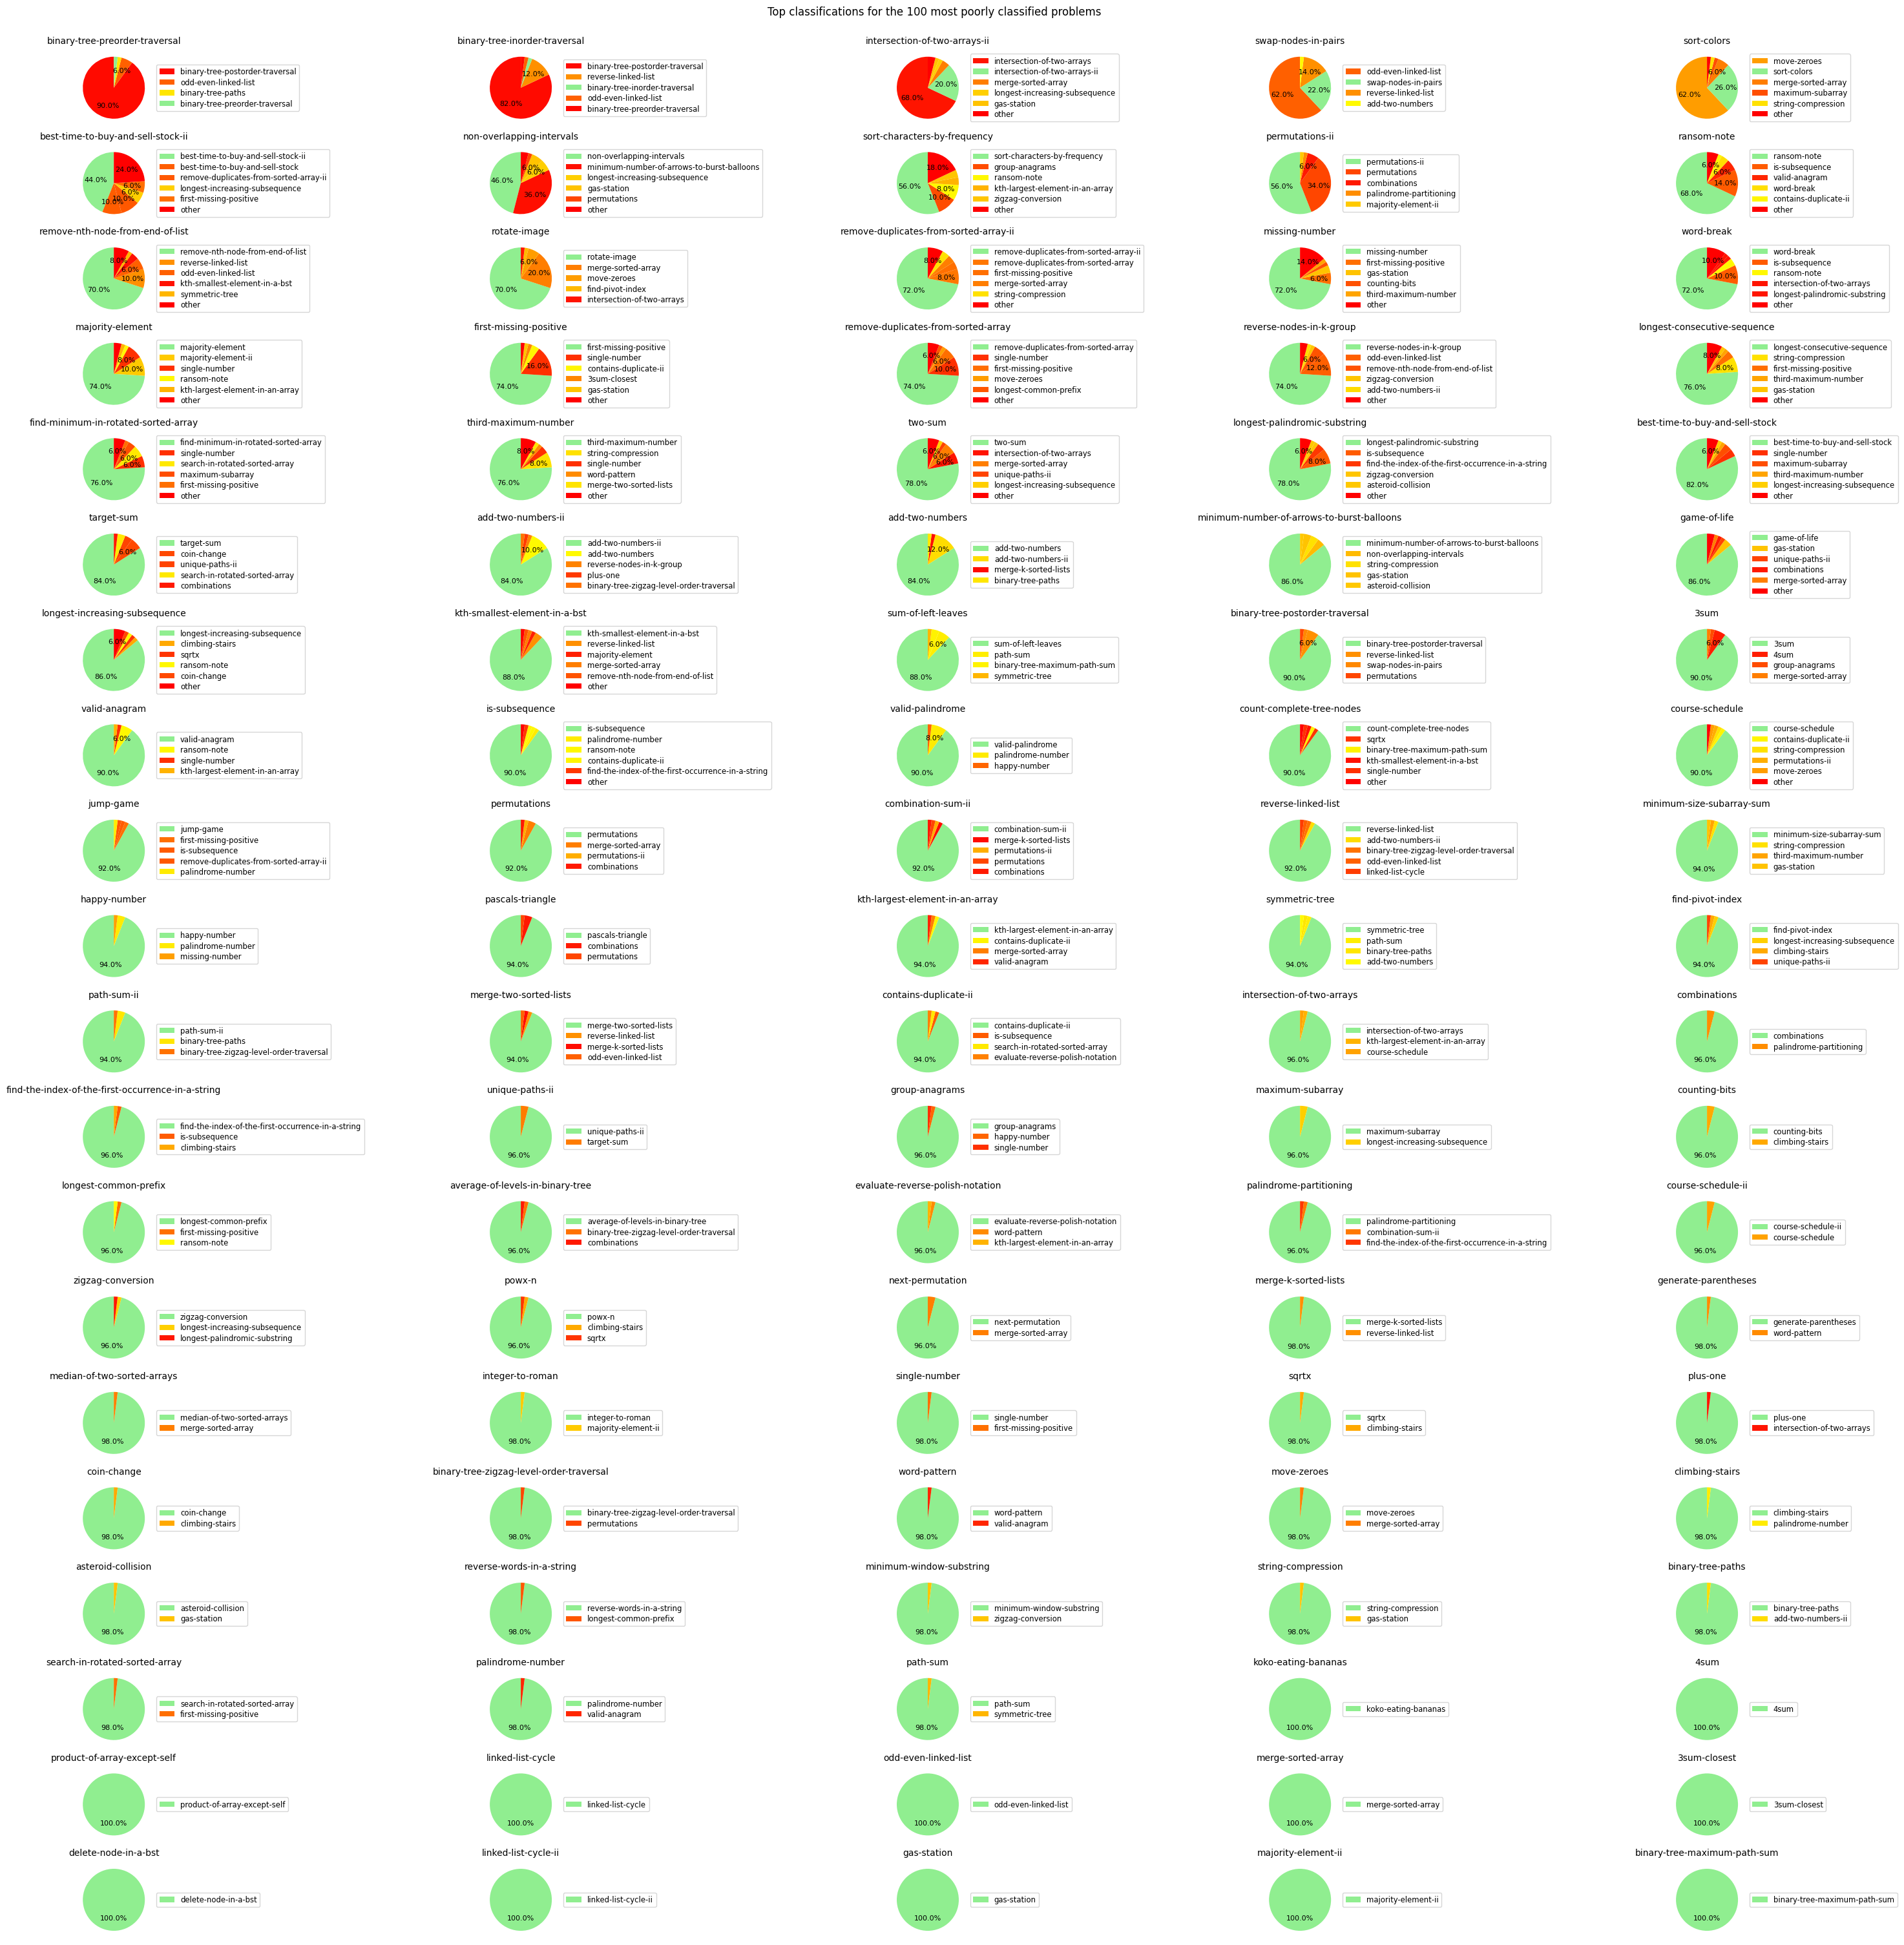

In [57]:
loaded_model.eval()  # Set model to evaluation mode

classes = {}
for i in range (NUM_CLASSES):
    classes[i] = (0, [])

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting Outputs"):
        batch = batch.to(device)
        out = loaded_model(batch.x, batch.edge_index, batch.batch)  # Shape: (batch_size, num_classes)
        max_idx = torch.argmax(out).item()
        actual_idx = torch.argmax(batch.y.float().reshape(1, NUM_CLASSES)).item()
        
        correct = 1 if max_idx == actual_idx else 0
        total_correct, class_outputs = classes[actual_idx]
        total_correct += correct
        class_outputs.append(out.cpu())
        classes[actual_idx] = (total_correct, class_outputs)

plot_classifications(classes, k=10)
plot_classifications(classes, k=10, best=True)
plot_problem_accuracies(classes)
plot_misclassifications(classes, n=100, k=5)